# Lorenz system

Starting from the data matrix $\mathbf{X}$ we have our approximated differential equation
$$
\mathbf{X'=\Theta(X)\Xi}
$$

To subpackes ```pysindy.differentiation```, ```pysindy.feature_library``` and ```pysindy.optimizers``` are used to "calculate" $\mathbf{X'}$, $\mathbf{\Theta}$ and $\mathbf{\Xi}$ respectively.

The Lorenz system used in paper has parameters $\sigma=10, \beta=\frac83,\rho=28$ and initial condition $(x(0),\ y(0),\ z(0))^T=(-8,\ 7,\ 27)^T$. So the system is 

$$
\begin{cases}
    x'=10(y-x)\\
    y'=x(28-z)-y\\
    z'=xy-\frac83 z
\end{cases}
$$

The time interval is $t\in[0,100]$ with time-step $\Delta t = 0.001$.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from scipy.integrate import solve_ivp
import pysindy as ps
from pysindy.utils import lorenz
np.random.seed(1000)

Note that from the ```lorenz``` from ```PySINDy``` has already the parameters we want by default.


In [2]:
lorenz

<function pysindy.utils.odes.lorenz(t, x, sigma=10, beta=2.66667, rho=28)>

To solve the ODE numerically I will use ```solve_ivp``` from ```SciPy```, which implements the Runge-Kutta method by default.

In [3]:
x0 = [-8, 8/3, 27]
delta_t = 0.001
time = np.arange(0, 100, delta_t)
xyz_data = solve_ivp(lorenz, (time[0], time[-1]), x0, t_eval=time).y.T
x_data = xyz_data[:, 0]
y_data = xyz_data[:, 1]
z_data = xyz_data[:, 2]

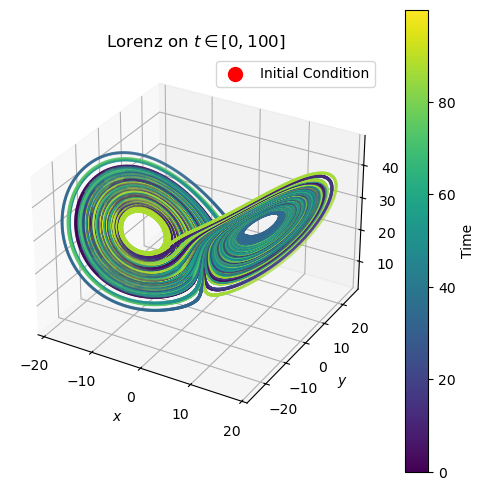

In [4]:
fig = plt.figure(figsize=(6, 6))
ax = fig.add_subplot(111, projection='3d')
scatter = ax.scatter(x_data, y_data, z_data, c=time, cmap='viridis', marker='.', linewidths=0.0001)
ax.scatter(x_data[0], y_data[0], z_data[0], color='red', s=100, label='Initial Condition')
ax.set(xlabel="$x$", ylabel="$y$", zlabel="$z$")
ax.legend()
plt.title("Lorenz on $t\in[0,100]$")
plt.colorbar(scatter, label='Time')
plt.show()

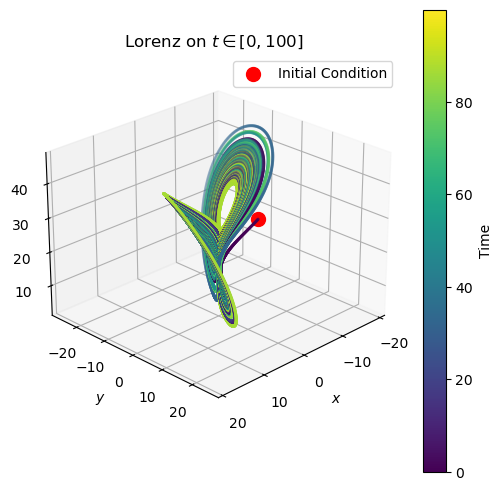

In [5]:
fig = plt.figure(figsize=(6, 6))
ax = fig.add_subplot(111, projection='3d')
scatter = ax.scatter(x_data, y_data, z_data, c=time, cmap='viridis', marker='.', linewidths=0.0001)
ax.scatter(x_data[0], y_data[0], z_data[0], color='red', s=100, label='Initial Condition')
ax.set(xlabel="$x$", ylabel="$y$", zlabel="$z$")
ax.legend()
plt.title("Lorenz on $t\in[0,100]$")
plt.colorbar(scatter, label='Time')
ax.view_init(azim = 45, elev = 25)
plt.show()

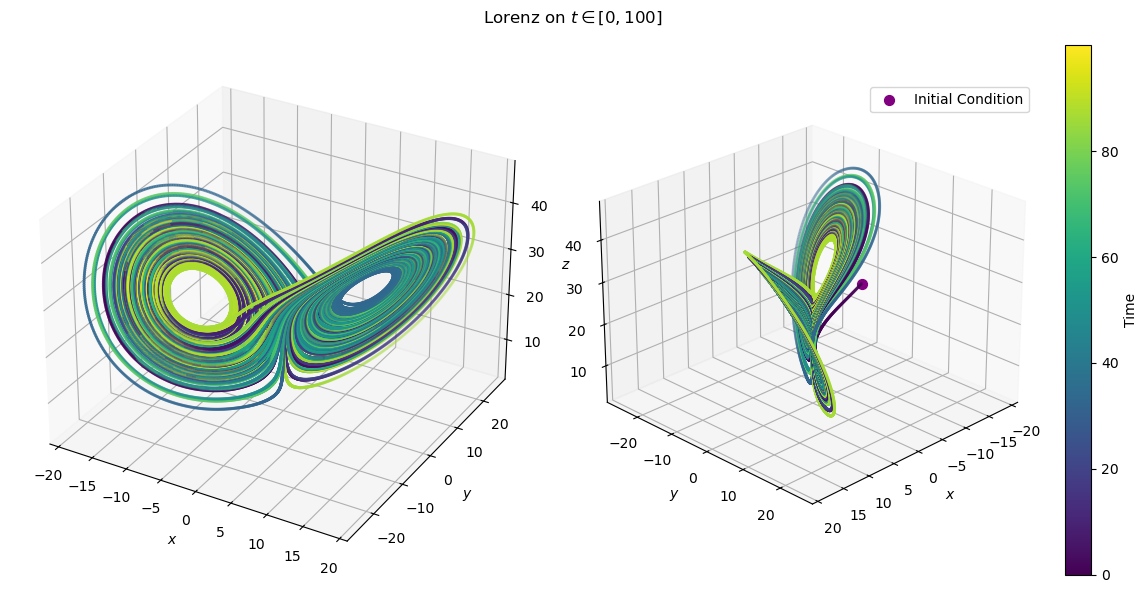

In [9]:
fig, axes = plt.subplots(1, 2, figsize=(12, 6), subplot_kw={'projection': '3d'})

# First subplot
scatter1 = axes[0].scatter(x_data, y_data, z_data, c=time, cmap='viridis', marker='.', linewidths=0.0001)
axes[0].set(xlabel="$x$", ylabel="$y$", zlabel="$z$")
# Second subplot
scatter2 = axes[1].scatter(x_data, y_data, z_data, c=time, cmap='viridis', marker='.', linewidths=0.0001)
axes[1].scatter(x_data[0], y_data[0], z_data[0], color='purple', s=50, label='Initial Condition')
axes[1].set(xlabel="$x$", ylabel="$y$")
axes[1].legend()
plt.colorbar(scatter2, ax=axes[1], label='Time')
axes[1].view_init(azim=45, elev=25)

fig.suptitle("Lorenz on $t\in[0,100]$")
plt.tight_layout()
plt.show()

add animation (for yourself)